In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
from torchvision import models
import torch.nn as nn
import torch.optim as optim

In [2]:
data_path = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "Datasets"))
print(data_path)


d:\level_3\Deep learning\project\Datasets


### Exploring Dataset Distribution
Let's expand on simply counting files in one directory. We will now count the number of images in each of the training subfolders (categories) and visualize their distribution. This gives a better overview of the dataset balance.

In [3]:

def explore(name:str):

  train_data_path = os.path.join(data_path, name)


  categories = [d for d in os.listdir(train_data_path) ]

  image_counts = {}
  image_dim={}
  for category in categories:
      category_path = os.path.join(train_data_path, category)
      image_counts[category] = len(os.listdir(category_path))
      # image_dim[category]=

  # Convert to DataFrame for easier visualization and display
  image_counts_df = pd.DataFrame(list(image_counts.items()), columns=['Category', 'Count'])

  print("Image counts per category:")
  display(image_counts_df)
    # Visualize the image counts
  plt.figure(figsize=(10, 6))
  sns.barplot(x='Category', y='Count', data=image_counts_df, palette='viridis', hue='Category', legend=False)
  plt.title(f'Number of Images per Category in {name} Dataset')
  plt.xlabel('Recycling Category')
  plt.ylabel('Number of Images')
  plt.xticks(rotation=45, ha='right')
  plt.tight_layout()
  plt.show()

Image counts per category:


,Category,Count
0,biological,700
1,cardboard,700
2,glass,471
3,metal,700
4,paper,700
5,plastic,700
6,trash,700


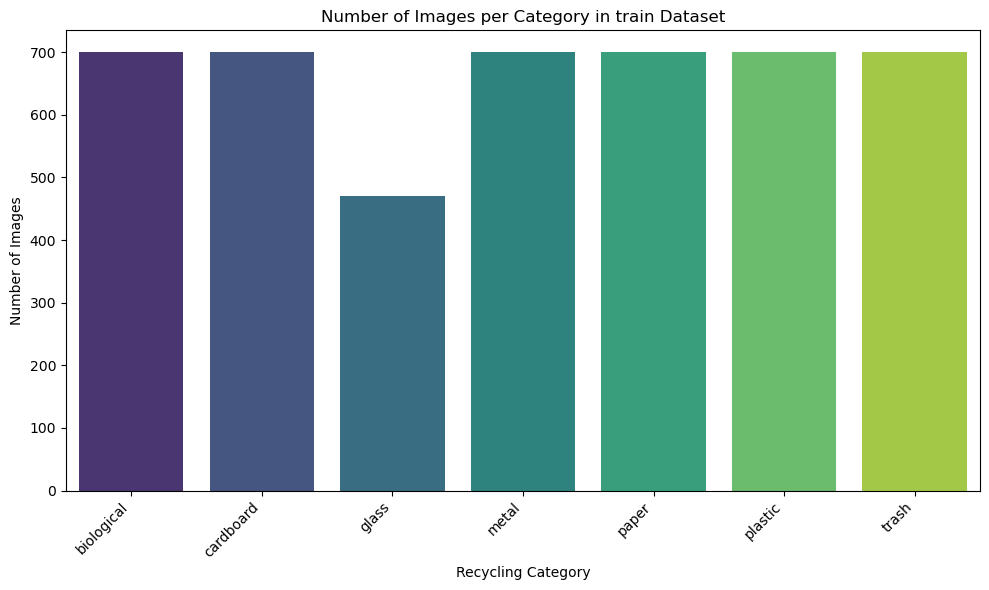

In [4]:
explore("train")

Image counts per category:


,Category,Count
0,biological,150
1,cardboard,150
2,glass,102
3,metal,150
4,paper,150
5,plastic,150
6,trash,150


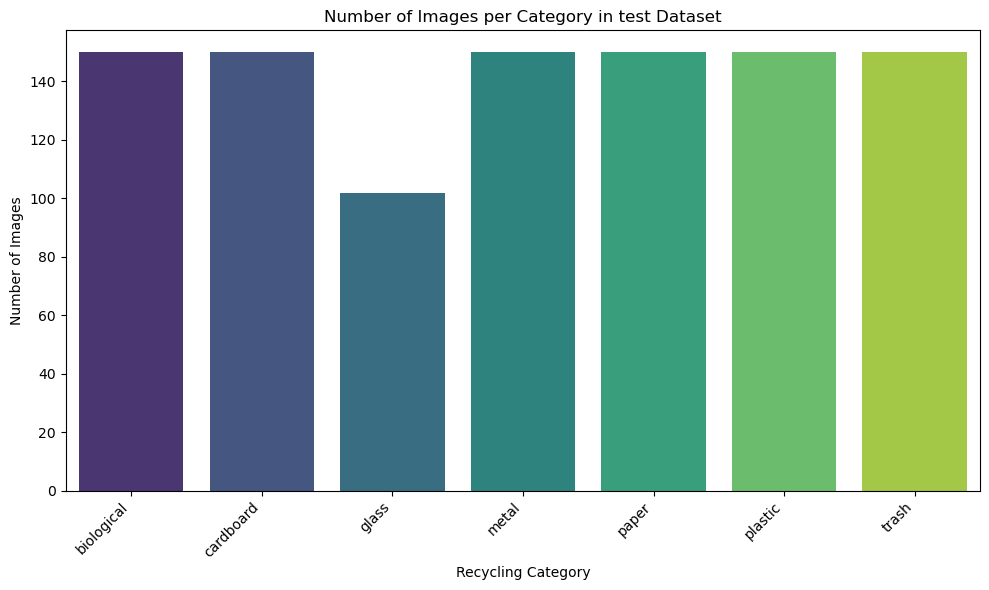

In [5]:
explore("test")

Image counts per category:


,Category,Count
0,biological,150
1,cardboard,150
2,glass,101
3,metal,150
4,paper,150
5,plastic,150
6,trash,150


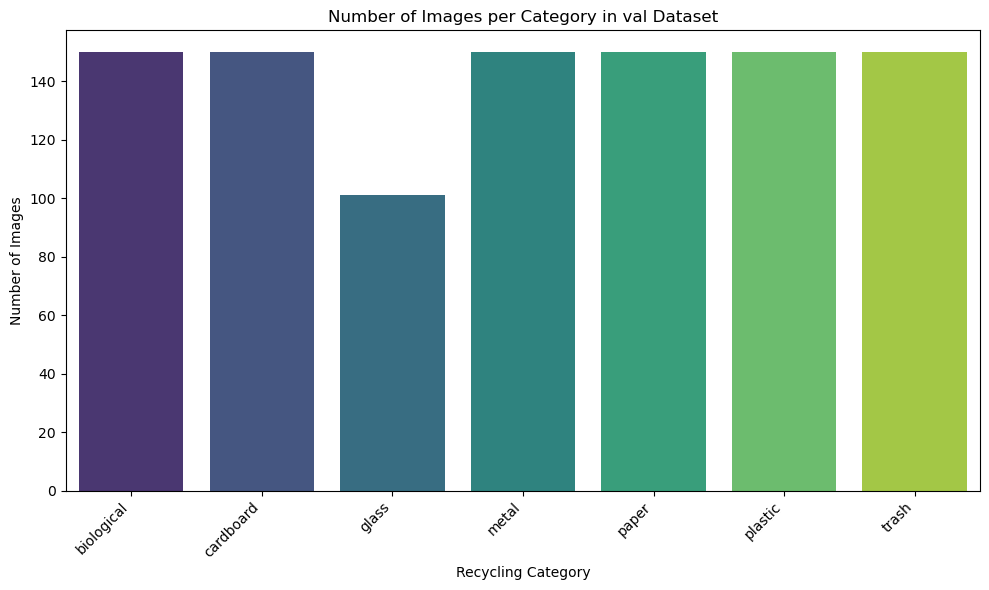

In [6]:
explore("val")

In [7]:
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2, 0.2),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
]) 

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

### Create Datasets and DataLoaders
Now that we have defined our image transformations, we will use `torchvision.datasets.ImageFolder` to create our datasets for the training, validation, and test sets. Then, we'll create `DataLoader` instances to handle batching and efficient loading of the data during model training.

In [8]:
# Define batch size
BATCH_SIZE = 2

# Create ImageFolder datasets for train, validation, and test
train_dataset = datasets.ImageFolder(os.path.join(data_path, 'train'), transform=train_transform)
val_dataset = datasets.ImageFolder(os.path.join(data_path, 'val'), transform=test_transform)
test_dataset = datasets.ImageFolder(os.path.join(data_path, 'test'), transform=test_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


In [9]:
train_dataset.class_to_idx

{'biological': 0,
 'cardboard': 1,
 'glass': 2,
 'metal': 3,
 'paper': 4,
 'plastic': 5,
 'trash': 6}

`prepare GPU`

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

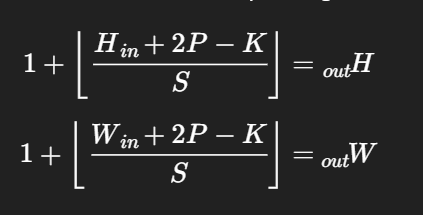

In [27]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

# CUDA Configuration
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'

# Reset CUDA
print("Resetting CUDA...")
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

# Configure cuDNN
torch.backends.cudnn.enabled = True
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = False

# Try GPU
print("Testing GPU...")
try:
    if torch.cuda.is_available():
        # Force init
        torch.cuda.init()
        torch.cuda.current_device()
        
        # Simple test
        test = torch.tensor([1.0], device='cuda')
        print("[OK] CUDA works!")
        device = 'cuda'
    else:
        device = 'cpu'
except Exception as e:
    print("[ERROR] {}".format(str(e)[:80]))
    print("[FALLBACK] Using CPU")
    device = 'cpu'

device = torch.device(device)
print("Device: {}".format(device))
print("-" * 60)

# -------- Hybrid Activation --------
class HybridAct(nn.Module):
    def forward(self, x):
        mish = x * torch.tanh(F.softplus(x))
        return 0.4 * F.gelu(x) + 0.3 * torch.sigmoid(x) * x + 0.3 * mish

# -------- Ghost Convolution --------
class GhostConv(nn.Module):
    def __init__(self, in_ch, out_ch, k=1, s=1, ratio=2):
        super().__init__()
        init_ch = out_ch // ratio
        new_ch = out_ch - init_ch
        
        self.primary = nn.Sequential(
            nn.Conv2d(in_ch, init_ch, k, s, k//2, bias=False),
            nn.BatchNorm2d(init_ch),
            HybridAct()
        )
        self.ghost = nn.Sequential(
            nn.Conv2d(init_ch, new_ch, 3, 1, 1, groups=init_ch, bias=False),
            nn.BatchNorm2d(new_ch),
            HybridAct()
        )
    def forward(self, x):
        x1 = self.primary(x)
        x2 = self.ghost(x1)
        return torch.cat([x1, x2], 1)

# -------- Coordinated Attention --------
class CoordAttention(nn.Module):
    def __init__(self, inp, reduction=32):
        super().__init__()
        mip = max(8, inp // reduction)
        self.conv1 = nn.Conv2d(inp, mip, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(mip)
        self.act = HybridAct()
        self.conv_h = nn.Conv2d(mip, inp, 1, bias=False)
        self.conv_w = nn.Conv2d(mip, inp, 1, bias=False)

    def forward(self, x):
        b, c, h, w = x.size()
        x_h = F.adaptive_avg_pool2d(x, (h, 1))
        x_w = F.adaptive_avg_pool2d(x, (1, w))
        y_h = self.act(self.bn1(self.conv1(x_h)))
        y_w = self.act(self.bn1(self.conv1(x_w)))
        a_h = torch.sigmoid(self.conv_h(y_h))
        a_w = torch.sigmoid(self.conv_w(y_w))
        return x * a_h * a_w

# -------- Dense Block --------
class DenseLayer(nn.Module):
    def __init__(self, in_ch, growth=16):
        super().__init__()
        self.norm = nn.BatchNorm2d(in_ch)
        self.act = HybridAct()
        self.conv = nn.Conv2d(in_ch, growth, 3, padding=1, bias=False)
    def forward(self, x):
        new = self.conv(self.act(self.norm(x)))
        return torch.cat([x, new], 1)

class DenseBlock(nn.Module):
    def __init__(self, ch, layers=3, growth=16):
        super().__init__()
        self.layers = nn.ModuleList([DenseLayer(ch + i*growth, growth) for i in range(layers)])
        self.out_ch = ch + layers*growth
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# -------- Deep Residual --------
class DeepResidual(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1):
        super().__init__()
        mid = out_ch // 4
        self.conv1 = GhostConv(in_ch, mid, s=stride)
        self.conv2 = GhostConv(mid, mid)
        self.conv3 = GhostConv(mid, out_ch)
        self.skip = nn.Identity()
        if stride != 1 or in_ch != out_ch:
            self.skip = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 1, stride),
                nn.BatchNorm2d(out_ch)
            )
        self.ca = CoordAttention(out_ch)
        self.act = HybridAct()

    def forward(self, x):
        identity = self.skip(x)
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.ca(out)
        return self.act(out + identity)

# -------- Model --------
class UltraMegaComplexCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.stem = nn.Sequential(
            GhostConv(3, 32),
            nn.MaxPool2d(3, stride=2, padding=1),
            GhostConv(32, 64),
        )
        self.stage1_res = DeepResidual(64, 128)
        self.stage1_dense = DenseBlock(128, layers=2, growth=8)
        self.stage1_reduce = nn.Conv2d(self.stage1_dense.out_ch, 128, 1)
        self.stage1_ca = CoordAttention(128)
        self.stage2_res1 = DeepResidual(128, 256, stride=2)
        self.stage2_dense = DenseBlock(256, layers=2, growth=8)
        self.stage2_reduce = nn.Conv2d(self.stage2_dense.out_ch, 256, 1)
        self.stage2_ca = CoordAttention(256)
        self.stage2_res2 = DeepResidual(256, 256)
        self.stage3_res1 = DeepResidual(256, 512, stride=2)
        self.stage3_dense1 = DenseBlock(512, layers=2, growth=8)
        self.stage3_reduce1 = nn.Conv2d(self.stage3_dense1.out_ch, 512, 1)
        self.stage3_res2 = DeepResidual(512, 512)
        self.stage3_ca = CoordAttention(512)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            HybridAct(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        x = self.stem(x)
        x = self.stage1_res(x)
        x = self.stage1_dense(x)
        x = self.stage1_reduce(x)
        x = self.stage1_ca(x)
        x = self.stage2_res1(x)
        x = self.stage2_dense(x)
        x = self.stage2_reduce(x)
        x = self.stage2_ca(x)
        x = self.stage2_res2(x)
        x = self.stage3_res1(x)
        x = self.stage3_dense1(x)
        x = self.stage3_reduce1(x)
        x = self.stage3_res2(x)
        x = self.stage3_ca(x)
        x = self.pool(x).flatten(1)
        x = self.fc(x)
        return x

# Create on CPU first
print("Creating model on CPU...")
model = UltraMegaComplexCNN()
print("[OK] Model created")

# Move to device
print("Moving to {}...".format(device))
if device.type == 'cuda':
    try:
        model = model.to(device)
        print("[OK] Model on GPU")
    except Exception as e:
        print("[FAILED] {}".format(str(e)[:50]))
        print("[FALLBACK] Moving to CPU")
        model = model.to('cpu')
        device = torch.device('cpu')
else:
    model = model.to(device)

# Test
print("Testing forward pass...")
with torch.no_grad():
    x = torch.randn(1, 3, 224, 224, device=device)
    y = model(x)

params = sum(p.numel() for p in model.parameters())
print("Total Parameters: {:,}".format(params))
print("Output Shape: {}".format(y.shape))
print("[SUCCESS] Model ready!")

Resetting CUDA...


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [22]:

def save_checkpoint(model, optimizer, epoch, best_val_acc, path="./model_checkpoints/last_checkpoint_implemented_model.pth"):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_val_acc': best_val_acc
    

    }
    path = "./model_checkpoints/last_checkpoint_implemented_model.pth"
    folder = os.path.dirname(path)
    os.makedirs(folder, exist_ok=True)
    torch.save(checkpoint, path)
    print(f" ✓ Checkpoint saved at epoch {epoch} → {path}")

def load_checkpoint(model, optimizer, path="./model_checkpoints/last_checkpoint_implemented_model.pth"):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_val_acc = checkpoint['best_val_acc']
    print(f"✓ Checkpoint loaded! Resuming from epoch {start_epoch}")
    return start_epoch, best_val_acc

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=25, device=device, resume=False):
    if resume:
        start_epoch, best_val_acc = load_checkpoint(model, optimizer)
    else:
        start_epoch, best_val_acc = 0, 0.0

    train_losses = []
    val_accuracies = []

    for epoch in range(start_epoch, epochs):
        
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (images, labels) in enumerate(train_loader, 1):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            batch_loss = loss.item()
            batch_acc = 100 * (predicted == labels).sum().item() / labels.size(0)
            print(f'Epoch [{epoch+1}/{epochs}] Batch [{batch_idx}/{len(train_loader)}] - Loss: {batch_loss:.4f}, Acc: {batch_acc:.2f}%')

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)

        model.eval()
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_acc = 100 * val_correct / val_total
        val_accuracies.append(val_acc)

    
        print(f'\nEpoch [{epoch+1}/{epochs}] Summary:')
        print(f'  Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%')
        print(f'  Val Acc: {val_acc:.2f}%')

       
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            save_path = "./best_model/best_model_implemented_model.pth"

            
            folder = os.path.dirname(save_path)

          
            os.makedirs(folder, exist_ok=True)

        
            torch.save(model.state_dict(), save_path)

            print("Model saved successfully!")
            print(f"  ✓ Best model saved! (Val Acc: {val_acc:.2f}%)")

      
        save_checkpoint(model, optimizer, epoch, best_val_acc)
        print()

    print(f'\n✓ Training Completed! Best Validation Accuracy: {best_val_acc:.2f}%')
    return train_losses, val_accuracies

`Prametarized adamw`

In [23]:
decay = []
no_decay = []
for name, param in model.named_parameters():
    if not param.requires_grad:
        continue
    if name.endswith(".bias") or "bn" in name.lower() or "norm" in name.lower():
        no_decay.append(param)
    else:
        decay.append(param)

optimizer = optim.AdamW(
    [
        {"params": decay, "weight_decay": 0.01},
        {"params": no_decay, "weight_decay": 0.0}
    ],
    lr=1e-3,         
    betas=(0.9, 0.999),
    eps=1e-8,
    amsgrad=False
)


In [24]:
criterion = nn.CrossEntropyLoss()

`run the model`

In [25]:
train_losses, val_accuracies = train_model(
    model, train_loader, val_loader,
    criterion, optimizer, epochs=30, resume=False, device=device
)

IndexError: Target 5 is out of bounds.

In [ ]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = RubbishCNN(num_classes=7).to(device)

# class RubbishCNN(nn.Module):
#     def __init__(self, num_classes=7):
#         super(RubbishCNN, self).__init__()

#         # Convolutional layers
#         self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
#         self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
#         self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

#         # Pooling layer
#         self.pool = nn.MaxPool2d(2, 2)

#         # Dropout for regularization
#         self.dropout = nn.Dropout(0.5)

#         # Fully connected layers
#         self.fc1 = nn.Linear(256 * 14 * 14, 512)  # 224/2/2/2/2 = 14
#         self.fc2 = nn.Linear(512, 256)
#         self.fc3 = nn.Linear(256, num_classes)

#     def forward(self, x):
#         # Convolutional layers with ReLU and pooling
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = self.pool(F.relu(self.conv3(x)))
#         x = self.pool(F.relu(self.conv4(x)))

#         # Flatten
#         x = x.view(-1, 256 * 14 * 14)

#         # Fully connected layers with dropout
#         x = F.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = F.relu(self.fc2(x))
#         x = self.dropout(x)
#         x = self.fc3(x)

#         return x


# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = RubbishCNN(num_classes=7).to(device)

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# def train_model(model, train_loader, criterion, optimizer, epochs=25):
#     model.train()
#     for epoch in range(epochs):
#         running_loss = 0.0
#         correct = 0
#         total = 0

#         for images, labels in train_loader:
#             images, labels = images.to(device), labels.to(device)

#             # Zero gradients
#             optimizer.zero_grad()

#             # Forward pass
#             outputs = model(images)
#             loss = criterion(outputs, labels)


#             loss.backward()
#             optimizer.step()


#             running_loss += loss.item()
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#         epoch_acc = 100 * correct / total
#         print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {epoch_acc:.2f}%')

# # Train the model
# train_model(model, train_loader, criterion, optimizer, epochs=25)

Epoch [1/25], Loss: 1.7278, Accuracy: 30.27%
Epoch [2/25], Loss: 1.5822, Accuracy: 37.55%
Epoch [3/25], Loss: 1.5114, Accuracy: 40.51%
Epoch [4/25], Loss: 1.4363, Accuracy: 45.04%
Epoch [5/25], Loss: 1.3906, Accuracy: 48.02%
Epoch [6/25], Loss: 1.3656, Accuracy: 49.90%
Epoch [7/25], Loss: 1.3153, Accuracy: 51.38%
Epoch [8/25], Loss: 1.2798, Accuracy: 53.29%
Epoch [9/25], Loss: 1.2390, Accuracy: 55.88%
Epoch [10/25], Loss: 1.2351, Accuracy: 54.74%
Epoch [11/25], Loss: 1.1814, Accuracy: 57.80%
Epoch [12/25], Loss: 1.1665, Accuracy: 58.25%
Epoch [13/25], Loss: 1.1398, Accuracy: 58.83%
Epoch [14/25], Loss: 1.1261, Accuracy: 59.92%
Epoch [15/25], Loss: 1.1263, Accuracy: 60.01%
Epoch [16/25], Loss: 1.0933, Accuracy: 61.66%
Epoch [17/25], Loss: 1.0541, Accuracy: 62.73%
Epoch [18/25], Loss: 1.0608, Accuracy: 63.16%
Epoch [19/25], Loss: 1.0360, Accuracy: 63.48%
Epoch [20/25], Loss: 1.0187, Accuracy: 64.35%
Epoch [21/25], Loss: 0.9853, Accuracy: 65.70%
Epoch [22/25], Loss: 1.0049, Accuracy: 65.4

In [ ]:
# from torch.cuda import device
# resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# for param in resnet.parameters():
#     param.requires_grad = False


# for param in resnet.layer4.parameters():
#     param.requires_grad = True

# num_features = resnet.fc.in_features
# resnet.fc = nn.Sequential(
#     nn.Linear(num_features, 512),
#     nn.ReLU(),
#     nn.Dropout(0.3),
#     nn.Linear(512, 7)
# )

# device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# resnet = resnet.to(device)


# optimizer = torch.optim.Adam([
#     {'params': resnet.layer4.parameters(), 'lr': 1e-5},
#     {'params': resnet.fc.parameters(), 'lr': 1e-4}
# ])

In [ ]:
# epochs = 10

# for epoch in range(epochs):
#     resnet.train()
#     running_loss = 0.0

#     for imgs, labels in train_loader:
#         imgs, labels = imgs.to(device), labels.to(device)

#         optimizer.zero_grad()
#         outputs = resnet(imgs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()

#     avg_loss = running_loss / len(train_loader)
#     print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f}")



#     resnet.eval()
#     correct = 0
#     total = 0

#     with torch.no_grad():
#         for imgs, labels in val_loader:
#             imgs, labels = imgs.to(device), labels.to(device)
#             outputs = resnet(imgs)
#             preds = outputs.argmax(dim=1)

#             correct += (preds == labels).sum().item()
#             total += labels.size(0)

#     acc = correct / total
#     print(f"Validation Accuracy: {acc:.4f}")




Epoch [1/10] - Loss: 1.0100
Validation Accuracy: 0.8801
Epoch [2/10] - Loss: 0.5281
Validation Accuracy: 0.8961
Epoch [3/10] - Loss: 0.4287
Validation Accuracy: 0.9141
Epoch [4/10] - Loss: 0.3708
Validation Accuracy: 0.9261
Epoch [5/10] - Loss: 0.3395
Validation Accuracy: 0.9301
Epoch [6/10] - Loss: 0.3084
Validation Accuracy: 0.9311
Epoch [7/10] - Loss: 0.2842
Validation Accuracy: 0.9381
Epoch [8/10] - Loss: 0.2779
Validation Accuracy: 0.9301
Epoch [9/10] - Loss: 0.2542
Validation Accuracy: 0.9311
Epoch [10/10] - Loss: 0.2297
Validation Accuracy: 0.9361


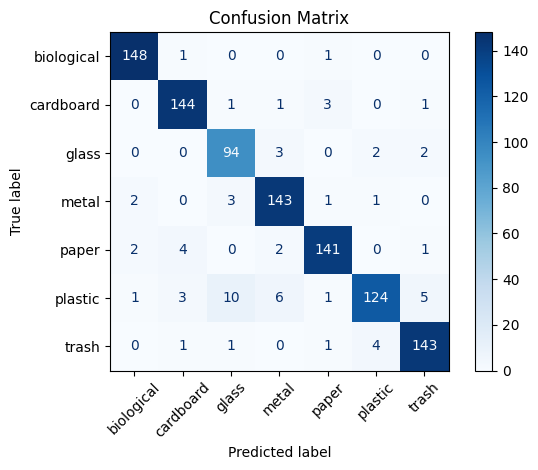

Classification Report:

              precision    recall  f1-score   support

  biological       0.97      0.99      0.98       150
   cardboard       0.94      0.96      0.95       150
       glass       0.86      0.93      0.90       101
       metal       0.92      0.95      0.94       150
       paper       0.95      0.94      0.95       150
     plastic       0.95      0.83      0.88       150
       trash       0.94      0.95      0.95       150

    accuracy                           0.94      1001
   macro avg       0.93      0.94      0.93      1001
weighted avg       0.94      0.94      0.94      1001



In [ ]:


# # ----------------------------
# # COLLECT ALL TRUE + PRED LABELS
# # ----------------------------
# all_preds = []
# all_labels = []

# resnet.eval()
# with torch.no_grad():
#     for imgs, labels in val_loader:
#         imgs = imgs.to(device)
#         labels = labels.to(device)

#         outputs = resnet(imgs)
#         preds = torch.argmax(outputs, dim=1)

#         all_preds.extend(preds.cpu().numpy())
#         all_labels.extend(labels.cpu().numpy())

# # ----------------------------
# # CONFUSION MATRIX
# # ----------------------------
# cm = confusion_matrix(all_labels, all_preds)
# classes = val_loader.dataset.classes  # class names from ImageFolder

# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
# disp.plot(xticks_rotation=45, cmap='Blues')

# plt.title("Confusion Matrix")
# plt.tight_layout()
# plt.show()

# # ----------------------------
# # CLASSIFICATION REPORT
# # ----------------------------
# report = classification_report(all_labels, all_preds, target_names=classes)
# print("Classification Report:\n")
# print(report)


In [ ]:
# # ----------------------------
# # SAVE MODEL
# # ----------------------------
# torch.save(resnet.state_dict(), "resnet_feature_extractor_7class.pth")
# print("Model saved.")

Model saved.
